# Entity extraction on Financial Complaints with Watson NLP

This notebook demonstrates how to extract _named entities_ from financial customer complaints using Watson NLP.

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), an U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains a consumer’s narrative description of their experience if the consumer opts to share this information publicly and after the CFPB has taken steps to remove all personal information. In this notebook, you will focus on complaints that contain narrative descriptions to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Dictionary-based term extraction** with the _Rule-based extractor_ provided by `watson_nlp.resources.feature_extractor.RBR`. This allows you to train a custom extraction model based on given dictionaries.

- **Entity extraction** with the _Entity mentions block_ using the BERT model (`entity-mentions_bert_multi_stock`). This block extracts mentions of entities like *Persion*, *Organization* or *Duration* from the input text.


## Table of Contents

1. [Before you start](#beforeYouStart)
2. [Load the complaints](#loadData)
3. [Custom term extraction using dictionaries](#dictionaries)
4. [Entity extraction](#entities)
5. [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _NLP_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [1]:
from tqdm import tqdm

In [2]:
import os
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [3]:
import watson_nlp

<a id="loadData"></a>
## Load the complaints

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. For this notebook, the complaints for one month will be downloaded and only those that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data is:

In [4]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.

You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In the analysis, you will focus on the *Product* column and the column with the complaint text *Consumer complaint narrative*.

In [5]:
df_all = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/23/21,Mortgage,Conventional home mortgage,Problem with a credit reporting company's investigation into an existing problem,None,"After calling LoanCare to sort out a new escrow amount, I Was advised by LoanCare Customer Service in XX/XX/2019 not make payment on mortgage until new/correct amount was determined. Was told that my payment would NOT be reported as late. Was advised I would be given 60 days days to solve issue of new payment amount. When advised of new amount I promptly made payment. Then got letter advising ...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"LoanCare, LLC",CA,95409,None,Consent provided,Web,03/29/21,Closed with explanation,Yes,NaN,4238609
1,03/23/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Personal information incorrect,"XXXX XXXX XXXX XXXX XXXX XXXX, Massachusetts XXXX Date of Birth : XX/XX/XXXX SS # : XXXX TransUnion LLC XXXX XXXX XXXX PO Box XXXX XXXX, PA XXXX To whom it may concern, I am writing to update my personal information. There are some mispelled incorrect names that are on my credit report and there are some fraudelant addresses that I've never lived. Please remove all fraudelant addresses and all...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MA,02121,None,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4239316
2,03/23/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,"I'm lost, I don't know what to do. I am a victim of identity thef and I need help because my credit has really been affecte. I have been asking for help and my lawyer told me to submit a complaint with the FTC. I have completed the report and have attached my documents for proof of ID. I can't take this, my family and I are being deepl affected by the reporting of these accounts that don't bel...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,11003,None,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4238026


You can look at all products that are available in the data set to do further analysis around these product groups.

<AxesSubplot:>

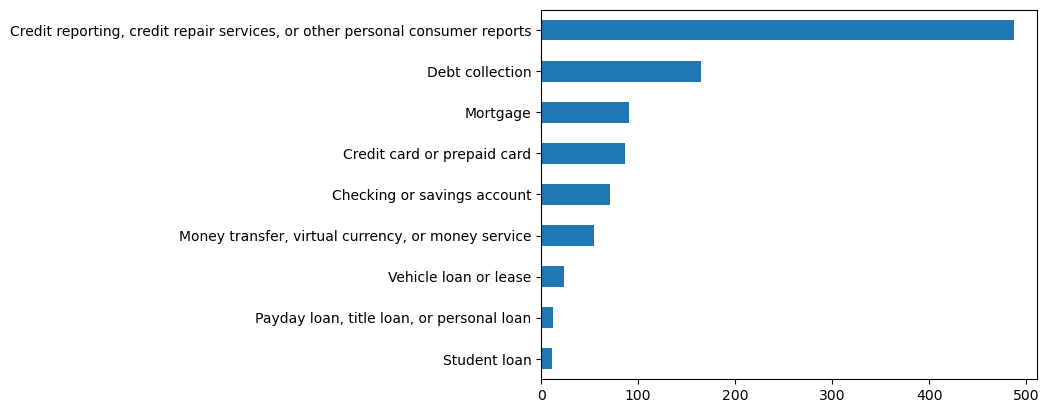

In [6]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

<a id="dictionaries"></a>
## Custom term extraction using dictionaries

If you want to extract custom concepts via rule-based extraction, you can build a custom RBR model using an AQL model. However this requires knowledge of AQL. If you just want to extract custom terms or match regular expression patterns, there is a convenient way to train and run such models through `watson_nlp.resources.feature_extractor.RBR`. You only need to provide your own dictionaries or regexes and it trains an RBR model for you.

You will now create a basic dictionary that contains terms that might indicate customers suspecting a fraud concerning their financial products like the theft of a credit card.

Start with creating a folder that holds all dictionary files that you want to use for extraction.

In [7]:
import os
RBR_dicts_folder = "RBR_dicts"
os.makedirs(RBR_dicts_folder, exist_ok=True)

A dictionary can contain the dictionary terms as a flat list if all the terms are to be mapped to the same label. Alternatively, you can use a mapping dictionary that maps terms to a label. 

In this notebook, you will create a dictionary mapping file containing the fraud-related terms divided into *FRAUD* and *THEFT*. Each line has one dictionary entry.

In [8]:
fraud_file = "fraud_mappings.csv"
with open(os.path.join(RBR_dicts_folder, fraud_file), 'w') as dict:
    dict.write("\"label\", \"entry\"\n")
    dict.write("\"FRAUD\", \"fraud\"\n")
    dict.write("\"FRAUD\", \"takeover\"\n")
    dict.write("\"FRAUD\", \"skimming\"\n")
    dict.write("\"FRAUD\", \"phishing\"\n")
    dict.write("\"THEFT\", \"theft\"\n")
    dict.write("\"THEFT\", \"thief\"\n")
    dict.write("\"THEFT\", \"thieve\"\n")
    dict.write("\"THEFT\", \"steal\"\n")

In the next step, load the file as dictionary. The source dictionary path is a relative path to the created dictionary resources folder. You will use case-insensitive matching as the dictionary entries are regular words that are not likely to be miss-interpreted.

Lemma-matching will make sure that inflections of the dictionary entries will also match, for example, "steal" -> "stole", "stolen", "stealing".

In [10]:
from watson_nlp.toolkit.rule_utils import DictionaryConfig

dictionary = DictionaryConfig.load( 
    {
        'name': 'fraud_mappings',
        'source': fraud_file,
        'dict_type': 'table',
        'case': 'insensitive',
        'lemma': True,
        'mappings': {
            'columns': ['label', 'entry'],
            'entry': 'entry'
        }
    }
)

Train the RBR model using the created dictionary. This will create the unterlying AQL code.

In [11]:
trained_dict_RBR = watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='en', dictionaries=[dictionary,])

As for the other demonstrated blocks before, create a helper method to run the RBR model on a single complaint. There is a `run()` method on the trained model, which returns the extracted concept and the span specifying the covered text.
But as you also want to see the covered text immediatly, you will access the raw response from the underlying RBR executor.

In [12]:
def extract_dictionary(complaint_text):
    RBR_result = trained_dict_RBR.executor.get_raw_response(complaint_text, language='en')
    # aggregate all matches into one array with the match label and the text evidence
    matches = []
    for view in RBR_result['annotations'].keys():
        for dict_match in RBR_result['annotations'][view]:
            matches.append(tuple((dict_match['label'], dict_match['match']['text'])))
    return matches

Now run the dictionary extraction on the complete dataframe and display the results with the complaint text.

In [13]:
# run dictionary extraction and create a dataframe holding the results
dict_matches = df[text_col].apply(lambda text: extract_dictionary(text))
dict_matches_df = pd.DataFrame(dict_matches)
dict_matches_df.rename(inplace=True, columns={text_col:'Fraud Indicators'})
# combine with the complaint dataframe
text_dict_matches_df = df[["Product", text_col]].merge(dict_matches_df, how='left', left_index=True, right_index=True)
text_dict_matches_df.head(10)

,Product,Consumer complaint narrative,Fraud Indicators
0,Mortgage,"After calling LoanCare to sort out a new escrow amount, I Was advised by LoanCare Customer Service in XX/XX/2019 not make payment on mortgage until new/correct amount was determined. Was told that my payment would NOT be reported as late. Was advised I would be given 60 days days to solve issue of new payment amount. When advised of new amount I promptly made payment. Then got letter advising ...",[]
1,"Credit reporting, credit repair services, or other personal consumer reports","XXXX XXXX XXXX XXXX XXXX XXXX, Massachusetts XXXX Date of Birth : XX/XX/XXXX SS # : XXXX TransUnion LLC XXXX XXXX XXXX PO Box XXXX XXXX, PA XXXX To whom it may concern, I am writing to update my personal information. There are some mispelled incorrect names that are on my credit report and there are some fraudelant addresses that I've never lived. Please remove all fraudelant addresses and all...",[]
2,"Credit reporting, credit repair services, or other personal consumer reports","I'm lost, I don't know what to do. I am a victim of identity thef and I need help because my credit has really been affecte. I have been asking for help and my lawyer told me to submit a complaint with the FTC. I have completed the report and have attached my documents for proof of ID. I can't take this, my family and I are being deepl affected by the reporting of these accounts that don't bel...",[]
3,Debt collection,XX/XX/2021 Americollect signed for certified letter sent certified letter requesting them to remove from my credit report due to violating XXXX laws. They continue sending me old bill with my XXXX XXXX. \nXX/XX/2021 Americollect signed for certified letter Americollect representatives continue to call and harass me stating I have to pay them or they will call me til I do.,[]
4,Mortgage,"Second filed complaint, original file number XXXX has not been resolved. Dovenmuehle Mortgage has provide false information regarding the details of my escrow refund. Supervising agents information is not inline with company 's response and no refund has been received. Each communication with Dovenmuehle Mortgage has been consistent and has shared miss leading and false information regarding r...",[]
5,Debt collection,"This is a debt that I was never notified of and I have no knowledge of this debt. When I disputed it no additional information was provided. No bill was sent to me prior to be sent over to a collections agency, which did not allow me to find out where it was coming from or if was a mistake.",[]
6,"Credit reporting, credit repair services, or other personal consumer reports",There are a couple of accounts listed on my reports that aren't mine. Please remove them.,[]
7,"Credit reporting, credit repair services, or other personal consumer reports","This company refuses to tell the whole story- eliminating critical data which favors the borrower and any lender may wish to see. They in effect provide an incomplete statement and misleading! "" This item already reflects that it has been paid. Whether the item was paid in full or paid in settlement, this item can not be disputed using this reason since it is already reflecting as Paid. In pay...",[]
8,Checking or savings account,"I attempted to put in a trade for NOK using Schwab 's brokerage services and a pop up notified me the trade was halted, so I cancelled but the trade went through an hour later when the stock tanked. Schwab has not provided a resolution for this.",[]
9,Credit card or prepaid card,"I am writing today in regards to my account with CitiCard account # XXXX. The reason for writing today is in regards to the late payment which is showing on my report in XX/XX/2020 and XX/XX/2020, due to Covid I was unable to make the payment in those months since I was impacted by Covid. As soon as I was able to, I got my payment made and caught up.",[]


Notice that "stolen" was detected as *THEFT* as the base-form *steal* is contained in the dictionary and you used lemma-matching.

How many complaints talk about *THEFT* or *FRAUD* or both? Count the complaints for each product group and display the relative frequency: 

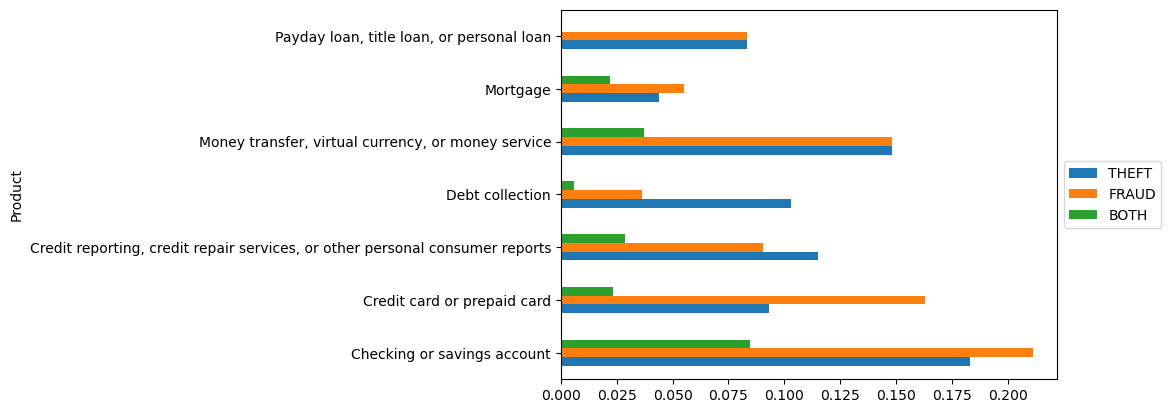

In [14]:
# create a column indicating if the complaint contains at least one *FRAUD* or *THEFT* match
text_dict_matches_df['THEFT'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'THEFT' in set([match[0] for match in matches]))
text_dict_matches_df['FRAUD'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]))
text_dict_matches_df['BOTH'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]) and 'THEFT' in set([match[0] for match in matches]))

# get the relative frequency by product group
perc_theft = text_dict_matches_df.groupby('Product')['THEFT'].value_counts(normalize=True)
perc_fraud = text_dict_matches_df.groupby('Product')['FRAUD'].value_counts(normalize=True)
perc_both = text_dict_matches_df.groupby('Product')['BOTH'].value_counts(normalize=True)
# combine the values into one dataframe
res = pd.concat([perc_theft, perc_fraud, perc_both], axis=1).reset_index().rename(columns={"level_1": "is_contained"})
# only use the counts for rows indicating a match
res = res[res['is_contained']].drop('is_contained', axis=1).set_index('Product')
res.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


Nearly 15% of the Money transfer/service complaints seem to deal with theft and over 25% of the checking or savings account complaints with fraud.

<a id="entities"></a>
## Entity extraction

The complaints contain a lot of entity mentions about entities like organizations, money, durations, etc. In this section you will learn how to use the BERT entity mention extraction block, which extracts entity mentions out-of-the-box. 

The BERT entity mention model depends on the syntax model. Start with loading both models:

In [15]:
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
bert_entity_model = watson_nlp.load('entity-mentions_bert_multi_stock')

The helper method first runs the syntax model and then the entity extraction model on top of the syntax result:

In [16]:
def extract_entities(complaint_text):
    # run syntax model
    syntax_result = syntax_model.run(complaint_text, parsers=('token', 'lemma', 'part_of_speech'))
    # run the entity mention model on the result of the syntax model
    entity_mentions = bert_entity_model.run(syntax_result)
    # get text and type of entities
    entities = entity_mentions.get_mention_pairs()
    return entities

Run the entity extraction model on the complaint dataframe and show the extracted entities along with the complaint text.<br/> **Note:** This cell will run for several minutes. For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. You can also use `apply` from `pandas` directly, i.e. `df[text_col].apply(..)`

In [17]:
from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

In [18]:
# run entity extraction and create a dataframe holding the results
entities = df[text_col].progress_apply(lambda text: extract_entities(text))
entities_df = pd.DataFrame(entities)
entities_df.rename(inplace=True, columns={text_col:'Entities'})
# combine with our complaint dataframe
text_entities_df = df[["Product", text_col]].merge(entities_df, how='left', left_index=True, right_index=True)
text_entities_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,Product,Consumer complaint narrative,Entities
0,Mortgage,"After calling LoanCare to sort out a new escrow amount, I Was advised by LoanCare Customer Service in XX/XX/2019 not make payment on mortgage until new/correct amount was determined. Was told that my payment would NOT be reported as late. Was advised I would be given 60 days days to solve issue of new payment amount. When advised of new amount I promptly made payment. Then got letter advising ...","[(LoanCare, Organization), (LoanCare, Organization), (2019, Date), (60 days days, Duration), (Loan Care Customer Service, Organization), (NEW, Organization), (Loan Care, Organization), (12 months, Duration), (60 day, Duration)]"
1,"Credit reporting, credit repair services, or other personal consumer reports","XXXX XXXX XXXX XXXX XXXX XXXX, Massachusetts XXXX Date of Birth : XX/XX/XXXX SS # : XXXX TransUnion LLC XXXX XXXX XXXX PO Box XXXX XXXX, PA XXXX To whom it may concern, I am writing to update my personal information. There are some mispelled incorrect names that are on my credit report and there are some fraudelant addresses that I've never lived. Please remove all fraudelant addresses and all...","[(XXXX, Date), (XXXX, Date), (XXXX, Date), (XXXX, Date), (XXXX, Location), (XXXX, Massachusetts, Location), (TransUnion LLC, Organization), (XXXX,, Location), (PA XXXX, Location), (XXXX, Date), (XXXX XXXX, Date), (XXXX, MA, Date), (XXXX, Date), (, MA, Date), (XXXX XXXX, Date), (XXXX XXXX, Date), (XXXX, MA, Date), (XXXX XXXX XXXX XXXX XXXX, Date), (XXXX, Date), (XXXX, MA, Date), (XXXX XXXX XXXX..."
2,"Credit reporting, credit repair services, or other personal consumer reports","I'm lost, I don't know what to do. I am a victim of identity thef and I need help because my credit has really been affecte. I have been asking for help and my lawyer told me to submit a complaint with the FTC. I have completed the report and have attached my documents for proof of ID. I can't take this, my family and I are being deepl affected by the reporting of these accounts that don't bel...","[(lawyer, JobTitle), (FTC, Organization), (FCRA, Organization), (4 business days, Duration)]"
3,Debt collection,XX/XX/2021 Americollect signed for certified letter sent certified letter requesting them to remove from my credit report due to violating XXXX laws. They continue sending me old bill with my XXXX XXXX. \nXX/XX/2021 Americollect signed for certified letter Americollect representatives continue to call and harass me stating I have to pay them or they will call me til I do.,"[(2021, Date), (Americollect, Organization), (2021, Date), (Americollect, Organization), (Americollect representatives, JobTitle)]"
4,Mortgage,"Second filed complaint, original file number XXXX has not been resolved. Dovenmuehle Mortgage has provide false information regarding the details of my escrow refund. Supervising agents information is not inline with company 's response and no refund has been received. Each communication with Dovenmuehle Mortgage has been consistent and has shared miss leading and false information regarding r...","[(Second, Ordinal), (Dovenmuehle Mortgage, Organization), (Dovenmuehle Mortgage, Organization), (5 months, Duration), (RESPA, Organization)]"


Let's see what kind of entities are extracted from the complaints:

<AxesSubplot:>

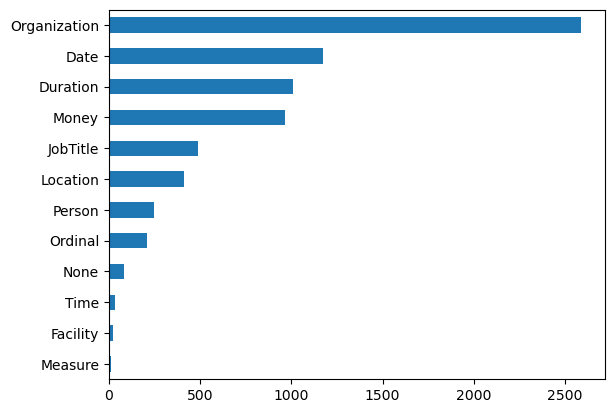

In [19]:
# helper method to extract the mention type from the (text, type) tuple
def get_entity_type(ent):
    if not pd.isna(ent):
        return ent[1]
    return 'None'

# create separate rows for each entity mention
exp_entities = text_entities_df.explode('Entities')
# extract the entity type of each mention
exp_entities['Entity Type'] = exp_entities['Entities'].apply(lambda ent: get_entity_type(ent))
# count the number of occurrences for each entity type
exp_entities['Entity Type'].value_counts().head(20).sort_values().plot(kind='barh') 

Show the relative frequency of each entity type by product:

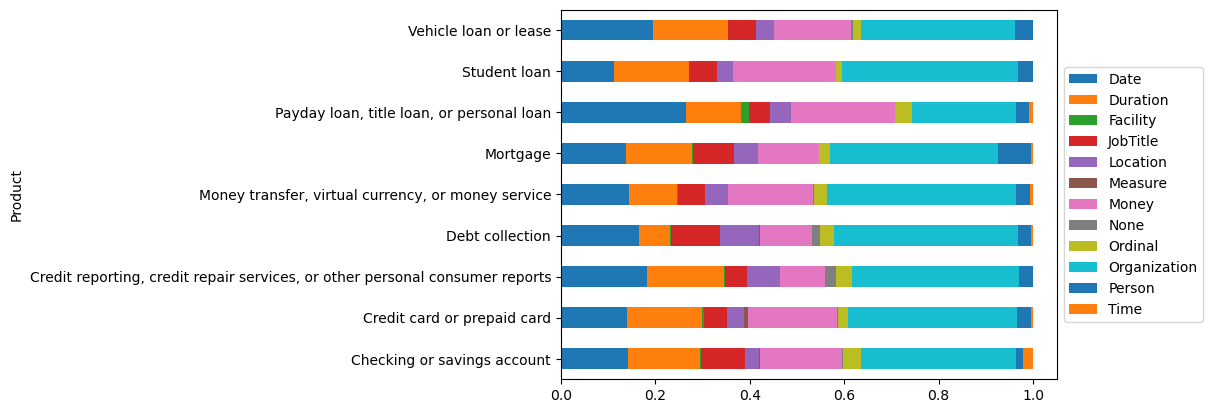

In [20]:
unstacked = exp_entities.groupby('Product')['Entity Type'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

*Job Titles* are frequently mentioned in the *Vechicle loan or lease* product group and there is a high number of *Location* mentions for the product group *Debt collection*. Let's look at some sample texts for the job titles:

In [21]:
exp_entities.query('`Entity Type` == "JobTitle" and Product == "Vehicle loan or lease"').head()

,Product,Consumer complaint narrative,Entities,Entity Type
30,Vehicle loan or lease,"On XX/XX/XXXX, my XXXX XXXX XXXX caught fire while I was driving and was completely destroyed. I immediately contacted my insurance company ( XXXX XXXX ), the dealership ( XXXX XXXX XXXX, XXXX XXXX Mi ) and US Bank, the lease holder. At every step, the dealership and US Bank said I had gap coverage, so any remaining balance after the the insurance company paid US Bank, would be zeroed out. The...","(attorney, JobTitle)",JobTitle
178,Vehicle loan or lease,"I purchased a vehicle from the used car dealership, XX/XX/XXXX ( XXXX, CA XXXX ) in about XXXX of 2020. I purchased the car for {$12000.00} from the dealership and put down {$2000.00} cash for deposit. I then financed the vehicle through California Auto Finance. During this time the covid crisis had gotten worse and financially I was looking for help with the finance company and asked to defer...","(CEO, JobTitle)",JobTitle
226,Vehicle loan or lease,My car was repossessed by Bank of America on XX/XX/2021. I called the bank prior to this and asked them if there was anything they could to do to help me. I told the customer service agent that I had family sending money to me through the mail to pay my balance due ( around {$400.00} ). A few days after that phone call they took my car. They didnt offer any sort of payment plan or deferment. I...,"(customer service agent, JobTitle)",JobTitle
386,Vehicle loan or lease,XX/XX/XXXX Sunday morning and I need to get my car payment receipt also all the monthly statement are missing. The XXXX XXXX XXXX original loan is being sent to the finance manager to get a new one. But the payment is being sent to the address on the wrong contacted the bank has been receiving the payment and XXXX customer service is being sent to the different codes for the capital one Auto f...,"(finance manager, JobTitle)",JobTitle
390,Vehicle loan or lease,"I was looking through my report and noticed a vehicle that I returned to the dealership where it's reporting completely incorrect. I had the opportunity to talk to several lawmakers and friends, and learned some basic laws in regards to voluntary or repossession of a vehicle. Under the laws of MASS and UCC 9.506 as well as State RISA and MVISA statutes, a deficiency can not be claimed unless a...","(lawmakers, JobTitle)",JobTitle


<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained model for entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.